In [1]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from data_util import *
from tensorflow.keras.layers import Dense,Input

## Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = load_mnist()

x_train: (60000, 28, 28)
y_train: (60000, 10)
x_test: (10000, 28, 28)
y_test: (10000, 10)


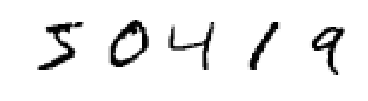

In [3]:
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
show_mnist(x_train[:5])

## Load Model

In [4]:
dae = load_model('models/dae.h5')
dae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_input (InputLayer)    (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              (None, 128)               100480    
_________________________________________________________________
decoder (Model)              (None, 28, 28)            101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________


## Base line NN

In [8]:
nn = load_model("models/classifier_without_bn.h5")
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28)            0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
_________________________________________________________________
output (Activation)          (None, 10)                0         
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


## Retrain NN

In [10]:
x_input = Input(shape=(28,28))

In [11]:
x_train_noisy = sap_noise(x_train, 0.3)

In [12]:
x_train_denoisy = dae.predict(x_train_noisy)

In [24]:
def reset_weights(model):
    session = k.backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [28]:
nn.fit(x_train_denoisy, y_train, batch_size=256, epochs=15)

Epoch 1/15
60000/60000 [==============================] - 1s 10us/step - loss: 0.1546 - acc: 0.9528
Epoch 2/15
60000/60000 [==============================] - 1s 10us/step - loss: 0.1410 - acc: 0.9560
Epoch 3/15
60000/60000 [==============================] - 1s 10us/step - loss: 0.1265 - acc: 0.9611
Epoch 4/15
60000/60000 [==============================] - 1s 9us/step - loss: 0.1176 - acc: 0.9644
Epoch 5/15
60000/60000 [==============================] - 1s 9us/step - loss: 0.1083 - acc: 0.9661
Epoch 6/15
60000/60000 [==============================] - 1s 9us/step - loss: 0.0993 - acc: 0.9697
Epoch 7/15
60000/60000 [==============================] - 1s 10us/step - loss: 0.0913 - acc: 0.9724
Epoch 8/15
60000/60000 [==============================] - 1s 10us/step - loss: 0.0860 - acc: 0.9739
Epoch 9/15
60000/60000 [==============================] - 1s 11us/step - loss: 0.0791 - acc: 0.9761
Epoch 10/15
60000/60000 [==============================] - 1s 10us/step - loss: 0.0729 - acc: 0.9785
Ep

### Save Model

In [38]:
nn.save("models/baseline_nn.h5")

In [5]:
nn = load_model("models/baseline_nn.h5")

## Baseline DAE-NN model

In [29]:
baseline = k.models.Model(x_input, nn(dae(x_input)))

In [35]:
baseline.summary()
baseline.compile(loss = "categorical_crossentropy",
                  optimizer="adam",
                  metrics = ['accuracy'],
                  )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
autoencoder (Model)          (None, 28, 28)            201616    
_________________________________________________________________
nnclassifier (Model)         (None, 10)                203530    
Total params: 405,146
Trainable params: 405,146
Non-trainable params: 0
_________________________________________________________________


### Save Model

In [37]:
baseline.save('models/baseline.h5')

In [11]:
baseline = load_model("models/baseline.h5")

## Compare

### BaseLine

In [25]:
def evaluate_acc(model):
    hists = []
    for i in range(11):
        noise_level = i / 10
        x_test_noise = sap_noise(x_test, noise_level)
        hist = model.evaluate(x_test_noise, y_test, verbose=0)
        title = "noise level:" + str(noise_level) + "\tAccuracy:" + str(hist[1])
        hists.append(hist)
    hists = np.array(hists)
    return hists

Text(0.5, 1.0, 'Predict with Noise')

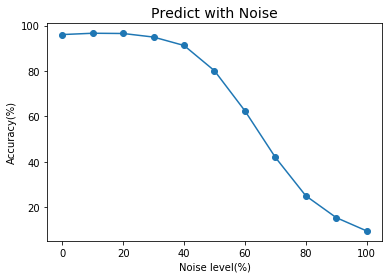

In [13]:
baseline_hists = evaluate_acc(baseline)
plt.plot(np.linspace(0,100,num=11),baseline_hists[:,1]*100, "-o")
plt.xlabel('Noise level(%)')
plt.ylabel('Accuracy(%)')
plt.title("Predict with Noise", fontsize=14)

In [15]:
nn = load_model("models/classifier_without_bn.h5")

Text(0.5, 1.0, 'Predict with Noise')

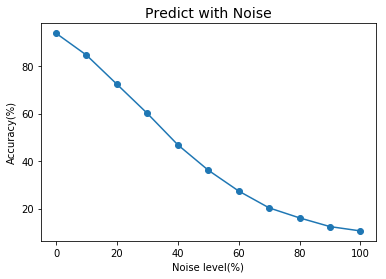

In [16]:
nn_hists = evaluate_acc(nn)
plt.plot(np.linspace(0,100,num=11),nn_hists[:,1]*100, "-o")
plt.xlabel('Noise level(%)')
plt.ylabel('Accuracy(%)')
plt.title("Predict with Noise", fontsize=14)

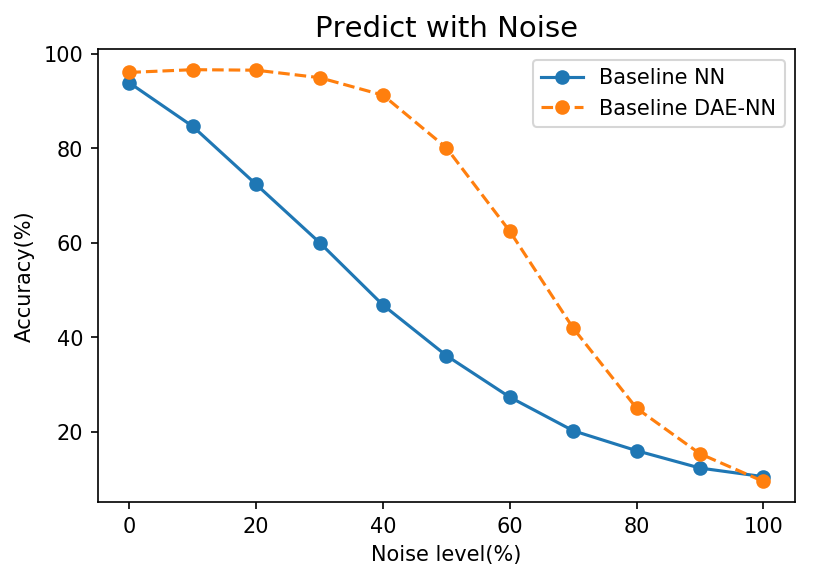

In [18]:
plt.figure(dpi=150)
plt.plot(np.linspace(0,100,num=11),nn_hists[:,1]*100, "-o", label ="Baseline NN")
plt.plot(np.linspace(0,100,num=11),baseline_hists[:,1]*100, "--o", label="Baseline DAE-NN")
plt.xlabel('Noise level(%)')
plt.ylabel('Accuracy(%)')
plt.title("Predict with Noise", fontsize=14)
plt.legend()

### New Model

In [19]:
conv_nn = load_model("models/conv_nn.h5")
dae_nn_conv = load_model("models/dae_nn_conv.h5")

In [26]:
conv_nn_hists = evaluate_acc(conv_nn)
dae_nn_conv_hists = evaluate_acc(dae_nn_conv)

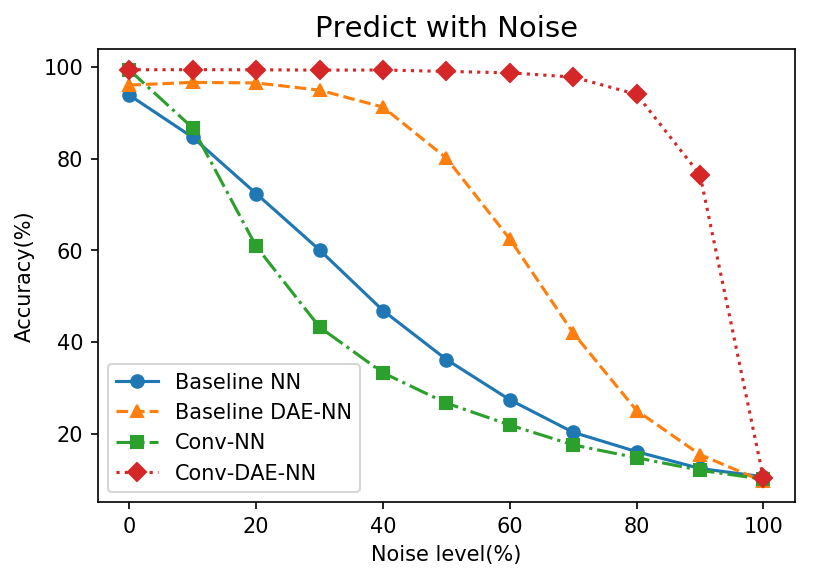

In [21]:
plt.figure(dpi=150)

plt.plot(np.linspace(0,100,num=11),nn_hists[:,1]*100, "-o", label ="Baseline NN")
plt.plot(np.linspace(0,100,num=11),baseline_hists[:,1]*100, "--^", label="Baseline DAE-NN")
plt.plot(np.linspace(0,100,num=11),conv_nn_hists[:,1]*100, "-.s", label="Conv-NN")
plt.plot(np.linspace(0,100,num=11),dae_nn_conv_hists[:,1]*100, ":D", label="Conv-DAE-NN")

plt.xlabel('Noise level(%)')
plt.ylabel('Accuracy(%)')
plt.title("Predict with Noise", fontsize=14)
plt.legend()